# Summarize test results and apply multiple testing correction

Control FDR for the pseudo-bulk and single-cell tests to prioritize peaks for further downstream analysis.

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.stats import probplot

from dali.utils.stats import apply_fdr_bh

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn

%config InlineBackend.figure_format = 'retina'

In [6]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader

## Global variables

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Load anndata

Load total counts anndata

In [8]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))
adata_total

AnnData object with n_obs × n_vars = 34053 × 25000
    obs: 'exp_id', 'timepoint', 'n_genes', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'n_counts', 'X_pca_0', 'size_vae', 'time_vae', 'leiden_vae', 'annotation', 'lineage_muscle', 'lineage_nervous'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance'
    uns: 'annotation_colors', 'enrichment', 'exp_id_colors', 'leiden', 'leiden_vae_colors', 'neighbors', 'pca', 'rank_genes_groups', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_vae'
    varm: 'PCs'
    layers: 'vae_peak_activities'
    obsp: 'connectivities', 'distances'

Load allele-specific anndata

In [9]:
adatas_allelic = dict()
for exp_id in settings.F1_EXP_IDS:
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adatas_allelic[exp_id] = sc.read(os.path.join(settings.DATA_DIR, label, fname))

Colors for crosses

In [10]:
cross_colors = dict(zip(adata_total.obs['exp_id'].cat.categories.tolist(), adata_total.uns['exp_id_colors']))

Swann's data

In [11]:
df_bulk = dataloader.load_imbalanced_peaks(exp_ids='f1', timepoints='all')

Peak overlaps

In [12]:
translation_table = pd.read_csv(os.path.join(settings.RESOURCES_DIR, 'imba_peaks', 'peak_translation.txt'), sep='\t', header=None)

translation_table['cusanovich_peaks'] = translation_table[[0, 1, 2]].apply(lambda x: '_'.join([str(e) for e in x]), 1)
translation_table['bulk_peaks'] = translation_table[[3, 4, 5]].apply(lambda x: '_'.join([str(e) for e in x]), 1)
translation_table = translation_table[['cusanovich_peaks', 'bulk_peaks']]

Peak annotations

In [13]:
peak_annotations = pd.read_csv(os.path.join(settings.RESOURCES_DIR, regions + '_annotated.txt'), sep='\t', index_col=0)

## Combine results and analyze

In [14]:
# extract p-values for all crosses
df_all = pd.DataFrame()

cols = [
    DALIHET_PVAL, 
    DALIJOINT_PVAL, 
    DALIHOM_PVAL,
    DALIJOINT_RHO
]
    
for exp_id, adata in adatas_allelic.items():    
    bulk_pvals = pd.merge(
        left=df_bulk.query('exp_id == "%s"' % exp_id), 
        right=translation_table, 
        left_on='peak', 
        right_on='bulk_peaks', 
        how='inner').groupby('cusanovich_peaks')['pval_adj'].min()
    shared_peaks = bulk_pvals.index.intersection(adata.var_names)

    df_sub = adata.var[cols]
    df_sub['bulk_pval'] = np.nan
    df_sub.loc[shared_peaks, 'bulk_pval'] = bulk_pvals[shared_peaks]
    
    df_sub = df_sub.reset_index()
    df_sub['exp_id'] = exp_id
    df_sub['pbulk_rate'] = adata.X.A.sum(0) / adata.layers['allelic_total'].A.sum(0)
        
    df_all = pd.concat([df_all, df_sub], ignore_index=True)

# reorder columns
df_all.columns = ['peak'] + df_all.columns[1:].tolist()

# add annotations
df_all = pd.merge(df_all, peak_annotations, how='left', left_on='peak', right_index=True)

# adjust rho
df_all[DALIJOINT_RHO] = 1 - df_all[DALIJOINT_RHO]

# add FDR correction separately for each test
cols = [DALIHET_PVAL, DALIHOM_PVAL, DALIJOINT_PVAL]
for col in [DALIHET_PVAL, DALIJOINT_PVAL, DALIHOM_PVAL]:
    df_all[col + '_bh'] = apply_fdr_bh(df_all[col].to_numpy())
    
df_all.head()

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


,peak,DALIHET_VAE,DALIJOINT,DALIHOM,DALIJOINT_RHO,bulk_pval,exp_id,pbulk_rate,TSS_1kb_peak,DHS_peak,...,MEF_peak,ELAV_peak,CAD_overlap,CAD_terms,BDGP_name,BDGP_terms,BDGP_dist,DALIHET_VAE_bh,DALIJOINT_bh,DALIHOM_bh
0,chr2L_5261_6261,0.011449,5.652263e-05,3.209529e-05,0.000000,NaN,SS148,0.445633,0,1,...,1,1,0,.,FBgn0002121,faint ubiquitous,3579,0.273467,1.062453e-03,6.618294e-04
1,chr2L_6273_7273,0.204462,2.149947e-01,2.023046e-01,0.777778,0.156782,SS148,0.492628,1,0,...,0,0,0,.,FBgn0002121,faint ubiquitous,2567,0.648719,4.374031e-01,4.441690e-01
2,chr2L_7282_8282,0.114362,1.340085e-01,7.619567e-02,0.111111,0.968144,SS148,0.478205,1,0,...,0,0,0,.,FBgn0002121,faint ubiquitous,1558,0.566850,3.348770e-01,2.453780e-01
3,chr2L_7938_8938,0.233088,6.004140e-22,1.465500e-21,0.333333,0.968144,SS148,0.360176,1,0,...,0,0,0,.,FBgn0002121,faint ubiquitous,902,0.667565,9.609055e-20,2.669641e-19
4,chr2L_18183_19183,0.747172,4.049562e-18,2.811349e-18,0.333333,0.019813,SS148,0.366043,1,1,...,1,1,1,"FBbt:0000607,ubiquitous; FBbt:0000607,ubiquito...",FBgn0002121,faint ubiquitous,0,0.911484,5.033937e-16,3.899390e-16


## FDR Plot

In [15]:
fdrs = np.linspace(0, .5, 100)
discoveries = pd.DataFrame()
for fdr in fdrs:
    discoveries = discoveries.append({
        'FDR': fdr, 
        'DALI-Joint': (df_all[DALIJOINT_PVAL + '_bh']  < fdr).sum(),
        'DALI-Het': (df_all[DALIHET_PVAL + '_bh']  < fdr).sum(),
        'DALI-Hom': (df_all[DALIHOM_PVAL + '_bh']  < fdr).sum(),
    }, ignore_index=True)
discoveries = discoveries.melt(id_vars='FDR', var_name='Test', value_name='Discoveries')

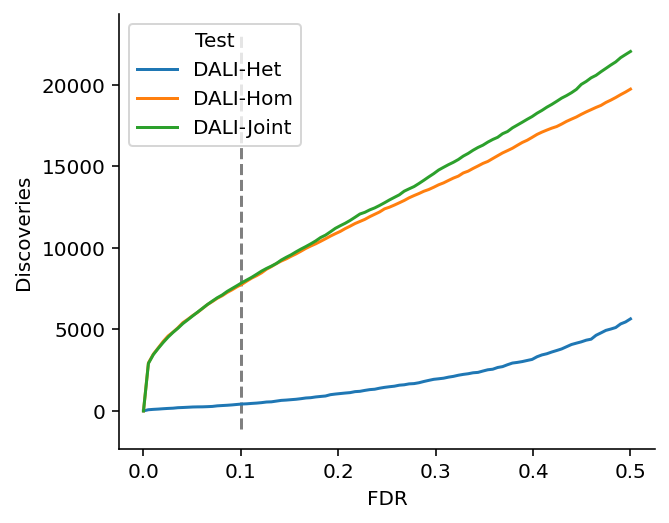

In [16]:
fig, ax = plt.subplots(figsize=(4.8, 4))
sns.lineplot(x='FDR', y='Discoveries', hue='Test', data=discoveries, ax=ax)
ax.vlines(.1, *ax.get_ylim(), linestyle='--', color='grey')
sns.despine()

## Overlap of discoveries at FDR 10%

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


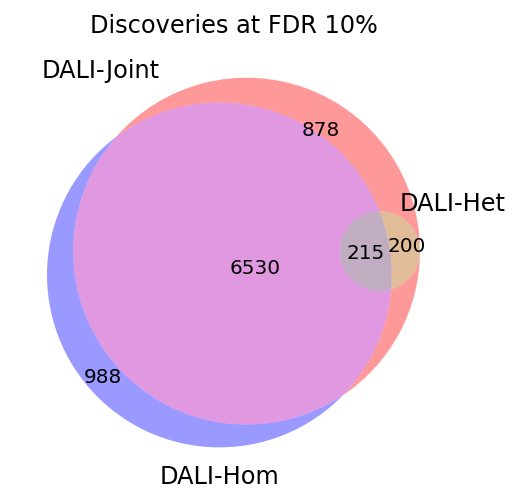

In [17]:
FDR_CUTOFF = .1
df = pd.DataFrame({
    'DALI-Joint': df_all[DALIJOINT_PVAL + '_bh']  < FDR_CUTOFF,
    'DALI-Het': df_all[DALIHET_PVAL + '_bh']  < FDR_CUTOFF,
    'DALI-Hom': df_all[DALIHOM_PVAL + '_bh']  < FDR_CUTOFF
})

df = df.reset_index().melt(id_vars='index')
df = df[df['value']].groupby('index')['variable'].unique().map(lambda x: '_'.join(x)).value_counts()

fig, ax = plt.subplots()
test_to_int = pd.Series(range(3), index=['DALI-Joint', 'DALI-Het', 'DALI-Hom'])

subsets = dict()
overlaps = df
for overlap in overlaps.index:
    subset_name = np.eye(3, dtype=int)[test_to_int.loc[overlap.split('_')], :].sum(0)
    subset_name = ''.join([str(x) for x in subset_name])
    subsets[subset_name] = overlaps.loc[overlap]
venn.venn3(subsets=subsets, set_labels=test_to_int.index.tolist(), ax=ax)
ax.set_title('Discoveries at FDR 10%');

## P-values and DALI-Joint $\rho$

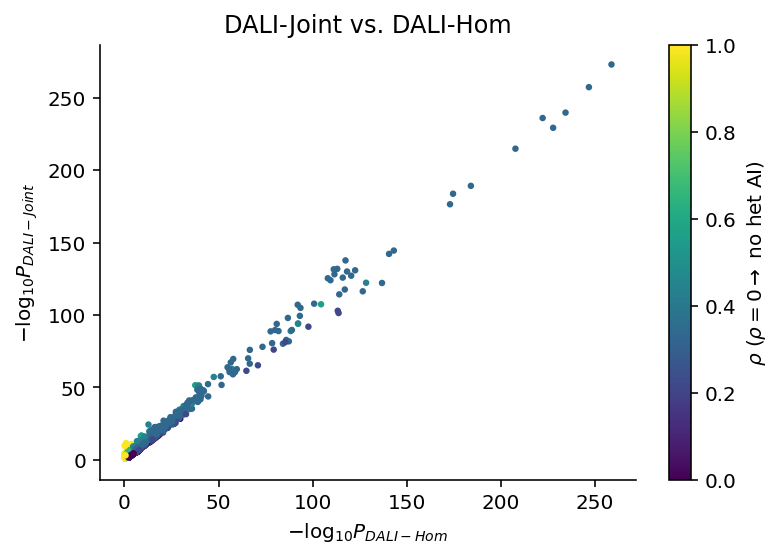

In [18]:
colors = sns.color_palette(plt.cm.viridis(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIJOINT_RHO]), desat=.2, as_cmap=True)

fig, ax = plt.subplots()
p = ax.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh > .1')[DALIJOINT_PVAL]), 
    c='lightgrey',
    s=.1)
p = ax.scatter(
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIHOM_PVAL]), 
    -np.log10(df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_PVAL]), 
    c=df_all.query(DALIJOINT_PVAL + '_bh < .1')[DALIJOINT_RHO],
    s=5)
ax.set(
    xlabel=r'$-\log_{10}P_{DALI-Hom}$',
    ylabel=r'$-\log_{10}P_{DALI-Joint}$',
    title='DALI-Joint vs. DALI-Hom')
plt.colorbar(p, label=r'$\rho$ ($\rho=0 \rightarrow$ no het AI)', ax=ax)
sns.despine()

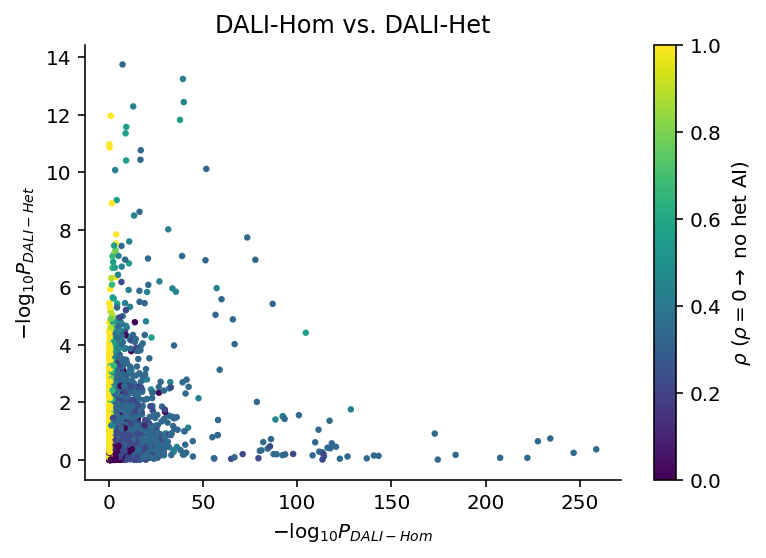

In [19]:
fig, ax = plt.subplots()
p = ax.scatter(
    -np.log10(df_all[DALIHOM_PVAL]), 
    -np.log10(df_all[DALIHET_PVAL]), 
    c=df_all[DALIJOINT_RHO], 
    s=5)
ax.set(
    xlabel=r'$-\log_{10}P_{DALI-Hom}$',
    ylabel=r'$-\log_{10}P_{DALI-Het}$',
    title='DALI-Hom vs. DALI-Het')
plt.colorbar(p, label=r'$\rho$ ($\rho=0 \rightarrow$ no het AI)')
sns.despine()

## QQ Plots

In [20]:
df = pd.DataFrame()
for test in [DALIHOM_PVAL, DALIHET_PVAL, DALIJOINT_PVAL]:
    for exp_id in df_all['exp_id'].unique():
            (osm, osr), _ = probplot(df_all.query('exp_id == @exp_id')[test].to_numpy(), dist='uniform')
            df = df.append(pd.DataFrame({
                'cross': exp_id, 
                'osm': -np.log10(osm), 
                'osr': -np.log10(osr), 
                'test': test
            }))
    (osm, osr), _ = probplot(df_all[test].to_numpy(), dist='uniform')
    df = df.append(pd.DataFrame({
        'cross': 'all', 
        'osm': -np.log10(osm), 
        'osr': -np.log10(osr), 
        'test': test}))

In [21]:
cross_colors['all'] = 'black'

Plot distribution of single-cell p-values for all regions by cross.

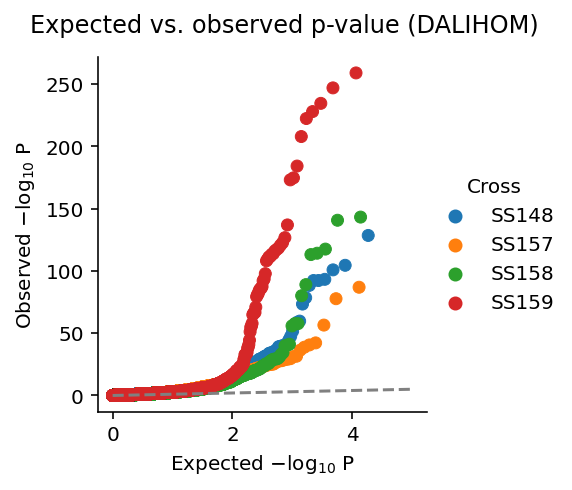

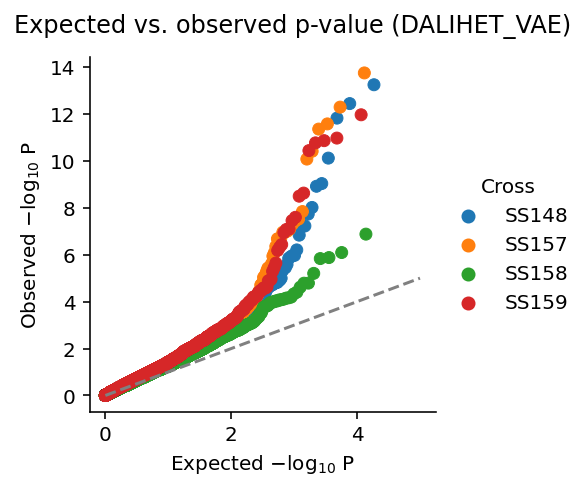

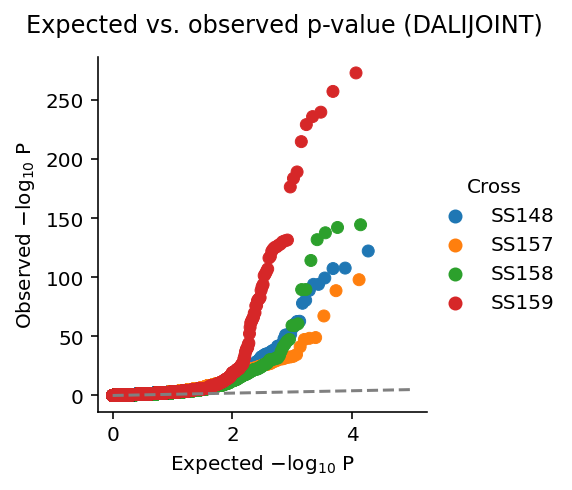

In [22]:
for test in df['test'].unique():
    g = sns.FacetGrid(df.query('test == "%s" and cross != "%s"' % (test, 'all')))
    g.map_dataframe(
        sns.scatterplot, 
        x='osm', y='osr', 
        hue='cross', data=df, 
        palette=cross_colors, 
        edgecolor=None)
    for ax in g.fig.axes: 
        ax.plot([0, 5], [0, 5], 'grey', linestyle='--')
    g.set_axis_labels(
        'Expected $-\log_{10}$ P', 
        'Observed $-\log_{10}$ P')
    g.fig.suptitle('Expected vs. observed p-value (%s)' % test, y=1.05)
    g.add_legend(title='Cross');

In [92]:
df_all['CAD_overlap'].sum() / df_all.shape[0]

0.0976726536807488

In [93]:
q = DALIJOINT_PVAL + '_bh < .1'
df_all.query(q)['CAD_overlap'].sum() / df_all.query(q).shape[0]

0.09587114917550811

In [94]:
q = DALIHOM_PVAL + '_bh < .1'
df_all.query(q)['CAD_overlap'].sum() / df_all.query(q).shape[0]

0.09349540928488297

In [95]:
q = DALIHET_PVAL + '_bh < .1'
df_all.query(q)['CAD_overlap'].sum() / df_all.query(q).shape[0]

0.10843373493975904

In [96]:
q = '(%s_bh < .1) and (%s_bh > .1)' % (DALIHET_PVAL, DALIHOM_PVAL)
df_all.query(q)['CAD_overlap'].sum() / df_all.query(q).shape[0]

0.14

In [97]:
q = '(%s_bh < .1) and (%s_bh > .1)' % (DALIHOM_PVAL, DALIHET_PVAL)
df_all.query(q)['CAD_overlap'].sum() / df_all.query(q).shape[0]

0.09390795424314978

## Save

In [23]:
# for exp_id, adata in adatas_allelic.items():
#     cols_to_add = df_all.columns.difference(adata.var.columns)
#     # add information to anndata
#     adata.var = pd.merge(
#         adata.var, 
#         df_all.query('exp_id == "%s"' % exp_id)[cols_to_add].set_index('peak').drop('exp_id', 1), 
#         how='left', right_index=True, left_index=True)
#     fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
#     sc.write(os.path.join(settings.DATA_DIR, label, fname), adata)
# df_all.to_csv(os.path.join(settings.DATA_DIR, label, 'results.txt'), sep='\t')